<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_explore_CPTAC_protein_abundances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example notebook exploring CPTAC protein abundances


Check out more notebooks at our [Community Notebooks Repository!](https://github.com/isb-cgc/Community-Notebooks)

```
Title:   Example notebook exploring CPTAC protein abundances
Author:  Boris Aguilar
Created: 01-19-2021
Purpose: Retrieve and analyze protein abundances from CPTAC
Notes:   This notebook recapitulates the following notebook https://pdc.cancer.gov/API_documentation/PDC_clustergram.html 
```
The notebook extracts protein abundances from the CPTAC Clear cell renal cell carcinoma (CCRCC) quant and their associated clinical metadata from the publicly available BigQuery tables that the ISB-CGC project has produced based on CPTAC. 
Finally, the notebook clusters and visualizes the data using the Seaborn clustermap package.


## Modules

In [56]:
from google.cloud import bigquery
from google.colab import auth
import seaborn as se
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt
from scipy.stats import zscore

## Defining helper functions

In [48]:
# A color mapping function for the clinical annotations
def get_colors(df, name, color) -> pd.Series:
    s = pd.Series( df[name]  ) 
    #s = df[name] 
    su = s.unique()
    colors = se.light_palette(color, len(su))
    lut = dict(zip(su, colors))
    return s.map(lut)

## Google Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Moreover you need to [create a google cloud](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console) project to be able to run BigQuery queries.

In [18]:
auth.authenticate_user()
my_project_id = "" # write your project id here

## Fetch the data
The following code obtains protein abundances and clinical metada for the all the cases in the CPTAC CCRCC study. Specifically we join two tables quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current and clinical_CPTAC3_discovery_pdc_current that host protein abundances and clinical metada, respectively. 

The results of query is automatically stored in pandas dataframe (quant_data) by the function read_gbq. 

In [19]:
sql = '''
SELECT pg.aliquot_submitter_id, pg.gene_symbol, 
       CAST(pg.protein_abundance_log2ratio as FLOAT64) as log2ratio,
       clin.tumor_stage, clin.primary_diagnosis 
FROM `isb-cgc-bq.CPTAC.quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current` as pg
JOIN `isb-cgc-bq.CPTAC.clinical_CPTAC3_discovery_pdc_current` as clin
ON pg.case_id = clin.case_id
'''
quant_data = pandas_gbq.read_gbq(sql,project_id=my_project_id )
quant_data


Downloading: 100%|██████████| 1985337/1985337 [01:38<00:00, 20156.62rows/s]


,aliquot_submitter_id,gene_symbol,log2ratio,tumor_stage,primary_diagnosis
0,NCI7-2,COX1,-0.2728,None,None
1,QC5,COX1,-0.7462,None,None
2,QC4,COX1,-0.8352,None,None
3,QC7,COX1,-0.6299,None,None
4,QC8,COX1,-0.9439,None,None
...,...,...,...,...,...
1985332,CPT0024680001,LZTR1,0.0672,Stage III,"Renal cell carcinoma, NOS"
1985333,CPT0066430001,LZTR1,-0.2127,Stage III,"Renal cell carcinoma, NOS"
1985334,CPT0009060003,LZTR1,-0.1471,Stage III,"Renal cell carcinoma, NOS"
1985335,CPT0006730001,LZTR1,-0.0764,Stage III,"Renal cell carcinoma, NOS"


## Analysis
The clustermap module within the Seaborn package does not allow for NaN values. So we must create a mask value that does not interfere much with the clustering and is likely to be unique.

In [21]:
mask_na = 0.000666
quant_data = quant_data.fillna(mask_na)

We then need to pivot the data. This step transforms the data from tidy format used in BigQuery to the format required by the clustermap function ( aliquot_submitter_id as columns and gene_symbol as rows ).

In [14]:
ga = pd.pivot_table(quant_data,values='log2ratio', 
                               index='gene_symbol', 
                               columns='aliquot_submitter_id')
print(ga.shape)

(9591, 207)


Next we set up colors for the clinical features *tumor_stage* and *primary_diagnosis*

In [54]:
labels = quant_data[['aliquot_submitter_id','tumor_stage','primary_diagnosis']].drop_duplicates().set_index('aliquot_submitter_id')
stage_col_colors = get_colors(labels, 'tumor_stage', 'red')
diagnosis_col_colors = get_colors(labels, 'primary_diagnosis', 'green')

#combine the two series into a dataframe
color_bars = pd.concat([stage_col_colors, diagnosis_col_colors], axis=1)

Finally we generate the clustergram

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


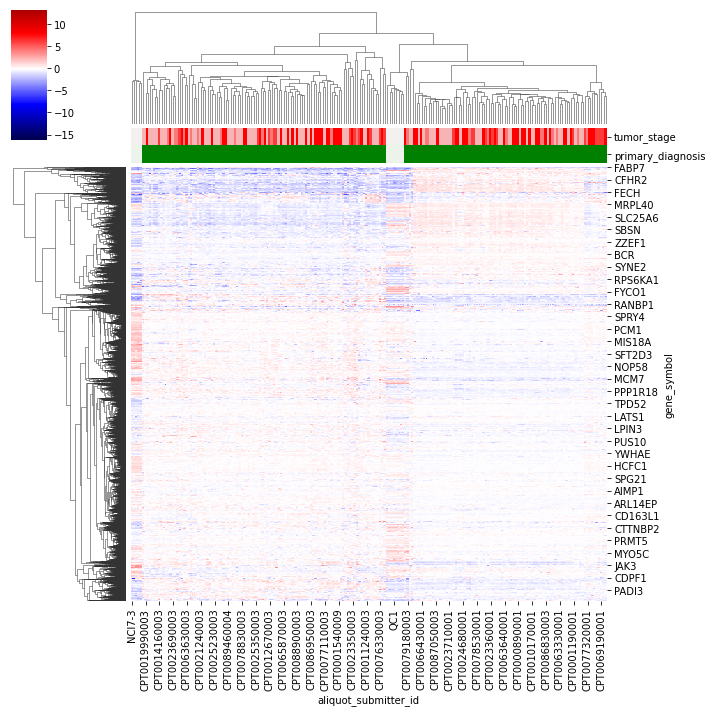

In [53]:
se.clustermap(ga, metric='euclidean', method='complete', cmap='seismic', mask=ga == 0.000666, center=0.,
              figsize=(10, 10) ,  col_colors = color_bars )
plt.show() #12.5 50

The clustergram shows the protein expression data grouped according to aliquot_submitter_id (columns) and gene_symbol (rows).

You could also convert the log2 ratio data to a standard statistic, like z-score. This can help compress the range, accounting for outliers.

In [57]:
zdf = ga.T.apply(zscore, ddof=len(ga.columns)-1)
zdf = zdf.T

And examine clustering according to that transformation.

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


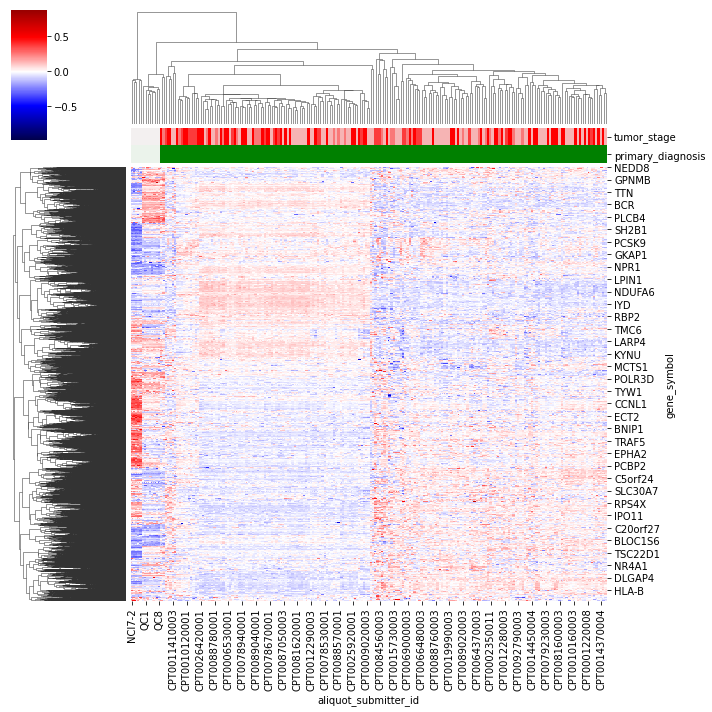

In [58]:
se.clustermap(zdf, metric='euclidean', method='complete', cmap='seismic', mask=ga == 0.000666, center=0.,
              figsize=(10, 10) ,  col_colors = color_bars )
plt.show() #12.5 50

This clustergram has a better grouping of the data. One can clearly distinguish a cluster of cell lines in the left hand side. Please compare this figure with the one generated by the PDC notebook in the following link https://pdc.cancer.gov/API_documentation/PDC_clustergram.html